In [5]:
!pip install jiwer
!pip install datasets

!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset, DatasetDict, concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate
#pip install jiwer

wer  = evaluate.load('wer')



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='hindi',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='hindi',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [8]:
sanskrit_text = 'हिरण्यवर्णां   हरिणीं   सुवर्णरजतस्रजाम्   ।'

tokenized_text = tokenizer(sanskrit_text)

tokenizer.decode(tokenized_text.input_ids)


'<|startoftranscript|><|hi|><|transcribe|><|notimestamps|>हिरण्यवर्णां   हरिणीं   सुवर्णरजतस्रजाम्   ।<|endoftext|>'

In [9]:
# Load the Sanskrit ASR dataset
dataset = load_dataset('parquet',data_files="/content/train-00000-of-00030.parquet")

# View the dataset splits
print(dataset)

# Access specific splits
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

# Check an example
print(train_data[0])


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audioFilename', 'snr', 'duration', 'gender', 'text', 'audio', '__index_level_0__'],
        num_rows: 1241
    })
})


KeyError: 'validation'

In [10]:
dataset = dataset.shuffle(seed=42)

# Split into train, validation, and test sets
train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)  # 10% val, 10% test

# Combine splits into a single dataset
final_dataset = {
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
}

print(final_dataset)


{'train': Dataset({
    features: ['audioFilename', 'snr', 'duration', 'gender', 'text', 'audio', '__index_level_0__'],
    num_rows: 992
}), 'validation': Dataset({
    features: ['audioFilename', 'snr', 'duration', 'gender', 'text', 'audio', '__index_level_0__'],
    num_rows: 124
}), 'test': Dataset({
    features: ['audioFilename', 'snr', 'duration', 'gender', 'text', 'audio', '__index_level_0__'],
    num_rows: 125
})}


In [11]:
# Select 1/3 of the train data
final_dataset['train'] = final_dataset['train'].select(range(len(final_dataset['train']) // 3))

# Select 1/3 of the test data
final_dataset['test'] = final_dataset['test'].select(range(len(final_dataset['test']) // 1))

In [13]:
# Concatenate train and validation sets
train_data = concatenate_datasets([final_dataset['train'], final_dataset['validation']])

# Keep the test set separate
test_data = final_dataset['test']

In [14]:
train_data.shape

(454, 7)

In [15]:
train_data[0]

{'audioFilename': '2_NSD-Sanskrit-Sanskrit-1810-1815-2018123118485.wav',
 'snr': {'methodDetails': {'snr': 100.0}, 'methodType': 'WadaSnr'},
 'duration': 5.85,
 'gender': 'female',
 'text': 'सम्प्रति वार्ताः शून्याम् तवा चिता कुशा कुमारी',
 'audio': {'array': [0.000152587890625,
   0.000213623046875,
   0.0003662109375,
   0.000518798828125,
   0.00054931640625,
   0.0003662109375,
   0.00018310546875,
   9.1552734375e-05,
   3.0517578125e-05,
   -0.000152587890625,
   -0.000457763671875,
   -0.0006103515625,
   -0.00048828125,
   -0.000244140625,
   -0.0001220703125,
   -0.00018310546875,
   -0.000152587890625,
   0.0,
   0.000152587890625,
   6.103515625e-05,
   -9.1552734375e-05,
   -6.103515625e-05,
   0.00018310546875,
   0.000396728515625,
   0.000335693359375,
   6.103515625e-05,
   -0.00018310546875,
   -0.00018310546875,
   -3.0517578125e-05,
   0.000213623046875,
   0.0003662109375,
   0.00030517578125,
   0.0,
   -0.000335693359375,
   -0.000457763671875,
   -0.0002746582031

In [16]:
text = train_data[0]['text']
tok_sentence = tokenizer(text)
tok_sentence

{'input_ids': [50258, 50276, 50359, 50363, 45938, 48521, 27099, 3941, 103, 27099, 25411, 36158, 33279, 8485, 113, 17937, 25411, 27099, 36158, 17937, 3941, 225, 8485, 114, 8703, 224, 35082, 27099, 48268, 17937, 48521, 27099, 8485, 97, 3941, 113, 17937, 8485, 248, 33279, 36158, 17937, 31970, 8703, 223, 3941, 114, 17937, 31970, 8703, 223, 48521, 17937, 25411, 31881, 50257], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.1)

<|startoftranscript|><|hi|><|transcribe|><|notimestamps|>सम्प्रति वार्ताः शून्याम् तवा चिता कुशा कुमारी


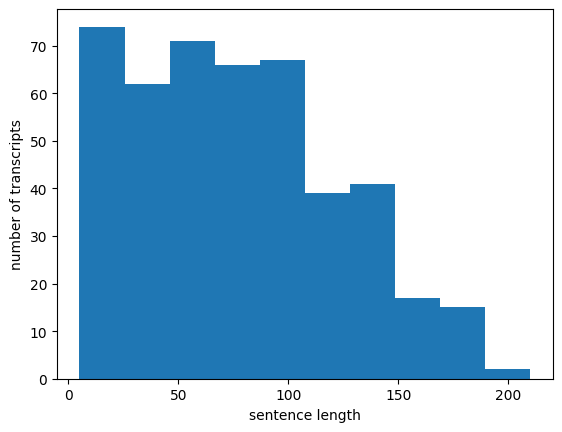

In [18]:
list_of_transcription_lengths=[]
tokenized_text = tokenizer(train_data['text']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    #break

plt.hist(list_of_transcription_lengths)
plt.xlabel('sentence length')
plt.ylabel('number of transcripts')
plt.show()

In [19]:
import torch

for idx in range(5):

    target = train_data[idx]['text']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='hindi', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------0------
true : सम्प्रति वार्ताः शून्याम् तवा चिता कुशा कुमारी 
pred :  सम्तति बार्ता हा, शूयान्ताम, तावाचिका, सुशमा कुमारी.

 
-------1------
true : सः समारुहत् समबोधयन् 
pred :  अदिएदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिदिद

 
-------2------
true : सङ्कल्पम् स्वीकुर्वन्तौ मुखवर्णम् सन् धारयन् तु 
pred :  अदियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियादियाद

 
-------3------
true : अवसरे तेन श्रीकालिद 
pred :  अब चारे इस्वे श्रीगो ये लोड

In [20]:
class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["text"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [21]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [22]:
def evaluation(model):

    device='cuda'

    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,  # Adjust batch size as needed
        shuffle=True,  # Shuffle data during training
    )

    model.eval()

    predictions=[]
    references=[]


    for batch in tqdm(test_dataloader,total=len(test_dataloader)):



        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features,language='hindi', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Filter out empty strings
        filtered_preds = [pred for pred in decoded_preds if pred.strip()]
        filtered_labels = [label for label in decoded_labels if label.strip()]

        predictions.extend(filtered_preds)
        references.extend(filtered_labels)



    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [25]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

 45%|████▌     | 5/11 [00:24<00:24,  4.16s/it]Exception ignored in: <generator object tqdm.__iter__ at 0x7f3b008e2e90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1290, in close
    fp_write('')
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1287, in fp_write
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
print(model.config.forced_decoder_ids)


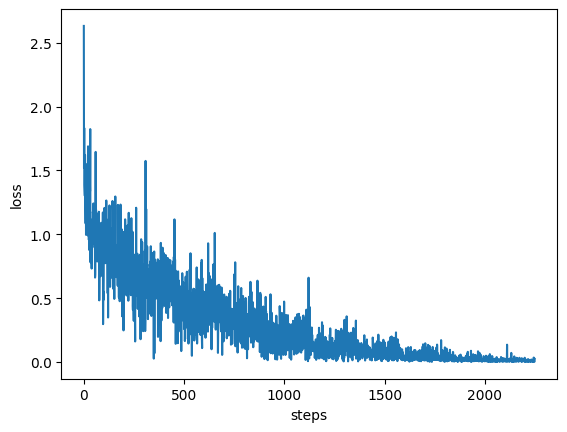

100%|██████████| 32/32 [02:01<00:00,  3.79s/it]


In [23]:
from IPython.display import clear_output
torch.cuda.empty_cache()

model.train()

device='cuda'


optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=10
accumulation_steps = 4  # Accumulate gradients over 2 steps

running_wer=[]
running_loss=[]



for epoch in range(max_epochs):

    for batch_idx, batch in enumerate(tqdm(train_dataloader,total=len(train_dataloader),leave=False)):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss / accumulation_steps  # Scale loss by accumulation steps

        # Backward pass and optimization
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:  # Update parameters every accumulation_steps
            optimizer.step()
            optimizer.zero_grad()  # Reset gradients

        running_loss.append(loss.item() * accumulation_steps)  # Store the unscaled loss

        if len(running_loss) % 50 ==0:  # Print loss every 50 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 100 steps
            torch.save(model.state_dict(), f'finetuned_on_sanskrit_steps_{len(running_loss)}.pth')
           # model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    running_wer.append(evaluation(model))

In [25]:
model.eval()



for idx in range(5):

    target = test_data[idx]['text']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='hindi', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : जहौ क्मरच् सम्प्राप्तः 
pred : जमौ कष्मीरम् सम्प्राप्नोति

 
-------1------
true : एतेषु षोडश 
pred : एतेशु शोडस्

 
-------2------
true : निर्ममः श्री नगरस्य आतङ्कग्रस्ता भटान् क्षेत्रे बली कार्य क्रमा यो कोऽपि आसीत् 
pred : नूर्महम् दः श्री नगरस्ते आतङ्कः ग्रस्ते बटमालुक् क्षत्रे दलीया कार्यक्षमा योज कोपि असीत्

 
-------3------
true : रज विहरति परिहर्तुम् करवालम् राक्षसान् स्म दरबार पूर्वोक्तम् चित्रम् शरत् 
pred : मर्कणी वजी हर्दी पूरिताः सम्प्रत् कोर्गन् कः राज्परम् श्वन्स देव भावानाम् कतार्पारः सायः कर्विदोस् कुन् दिन्च तक्रिवम् शरकत्

 
-------4------
true : पताकायाम् नवे करम् विद्यते 
pred : पद क्तालिकायम् नवमे क्रमे विद्यते

 
